<center><h1>Oligopoly Setting</h1></center>

In [ ]:
# Standard library
import nest_asyncio
import asyncio
import json
import os
import sys
import warnings

sys.path.append(os.path.abspath(os.path.join("../..")))

# Third-party libraries
import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Local application imports
from utils.prompts import GENERAL_PROMPT, P1, P2
from utils.pricing_market_logic_multiproduct import (
    get_monopoly_prices,
    get_nash_prices,
    get_profits,
    get_quantities,
)
from utils.utils import (
    create_output_paths,
    save_round_data,
    simulate_n_firms_round,
    update_plot,
)

# Apply third-party setup
nest_asyncio.apply()

# Load environment variables
load_dotenv()

# Configuration
API_KEY = os.getenv("MISTRAL_API_KEY")
MODEL_NAME = os.getenv("MODEL_NAME", "magistral-small-2506")

# Optional: Ignore specific warning types
warnings.filterwarnings("ignore", category=SyntaxWarning)

# Experiments
---

In total they run 42 experiments:
 - 21 using P1, where:
    - 7 where using $\alpha=1$
    - 7 where using $\alpha=3.2$
    - 7 where using $\alpha=10$
 - 21 using P2, where:
    - 7 where using $\alpha=1$
    - 7 where using $\alpha=3.2$
    - 7 where using $\alpha=10$

KeyboardInterrupt: 

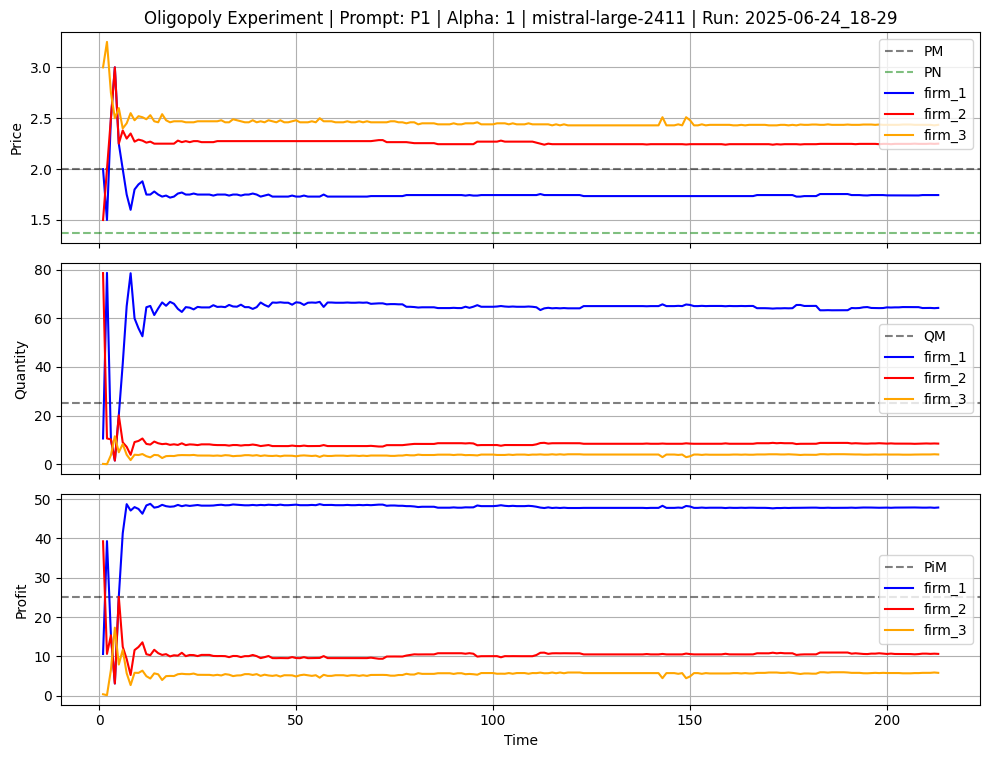

In [ ]:
N_FIRMS = 3
MARGINAL_COST = 1.0
N_PERIODS = 300
N_ROUNDS = 3
for PROMPT_NUMBER, PROMPT_PREFIX in enumerate([P1, P2], start=1):
    for ALPHA in [1, 3.2, 10]:
        a0 = 0.0
        a = tuple([2.0 for _ in range(N_FIRMS)])
        mu = 0.25
        alpha = tuple([ALPHA for _ in range(N_FIRMS)])
        c = tuple([MARGINAL_COST for _ in range(N_FIRMS)])
        beta = 100
        sigma = 0  # critical: this disables nesting → standard logit
        group_idxs = tuple([i for i in range(1, N_FIRMS + 1)])
        WILLIWGNES_TO_PAY = 4.51 * ALPHA

        monopoly_prices = get_monopoly_prices(
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            c=c,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
        )
        nash_prices = get_nash_prices(
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
            c=c,
        )

        monopoly_q = get_quantities(
            p=tuple(monopoly_prices),
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
        )

        monopoly_profits = get_profits(
            p=tuple(monopoly_prices),
            c=c,
            a0=a0,
            a=a,
            mu=mu,
            alpha=alpha,
            multiplier=beta,
            sigma=sigma,
            group_idxs=group_idxs,
        )
        print(f"Monopoly prices: {monopoly_prices} | Nash prices: {nash_prices}")
        print(
            f"Monopoly profits: {monopoly_profits} | Monopoly quantities: {monopoly_q}"
        )

        for _ in range(N_ROUNDS):
            p_m = monopoly_prices[0]
            p_nash = nash_prices[0]
            q_m = monopoly_q[0]
            pi_m = monopoly_profits[0]
            firm_names = [f"firm_{i + 1}" for i in range(N_FIRMS)]
            sub_path = f"oligopoly/prompt_{PROMPT_NUMBER}-alpha_{int(ALPHA)}"
            paths = create_output_paths(
                sub_path=sub_path, model_name=MODEL_NAME, firm_names=firm_names
            )

            plans = {firm: "No previous plans." for firm in firm_names}
            insights = {firm: "No previous insights." for firm in firm_names}
            market_data = {firm: "No previous market data." for firm in firm_names}

            # Initialize the market data file
            experiment_results = {
                "price_history": {k: [] for k in firm_names},
                "quantity_history": {k: [] for k in firm_names},
                "profit_history": {k: [] for k in firm_names},
                "time_history": [],
            }

            fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
            plt.tight_layout()

            for i in range(1, N_PERIODS + 1):
                # 1) Generate dict with prompts per firm
                agent_prompt_dict = {
                    firm_name: {
                        "prompt": GENERAL_PROMPT.format(
                            marginal_cost=MARGINAL_COST,
                            willigness_to_pay=WILLIWGNES_TO_PAY,
                            previous_plans=plans[firm_name],
                            previous_insights=insights[firm_name],
                            market_data=market_data[firm_name],
                        ),
                        "prefix": PROMPT_PREFIX,
                    }
                    for firm_name in firm_names
                }

                # Firms act simultaneously (async prompts)
                results = asyncio.run(simulate_n_firms_round(agent_prompt_dict))
                firm_responses = {
                    result["firm"]: result["response"] for result in results
                }

                # Get chosen prices
                prices = [firm_responses[firm]["chosen_price"] for firm in firm_names]

                # Compute quantities and profits for each firm, based on the chosen prices
                quantities = get_quantities(
                    p=tuple(prices),
                    a0=a0,
                    a=a,
                    mu=mu,
                    alpha=alpha,
                    multiplier=beta,
                    sigma=sigma,
                    group_idxs=group_idxs,
                )
                profits = get_profits(
                    p=tuple(prices),
                    c=c,
                    a0=a0,
                    a=a,
                    mu=mu,
                    alpha=alpha,
                    multiplier=beta,
                    sigma=sigma,
                    group_idxs=group_idxs,
                )
                # Save the results for each firm
                for firm in firm_names:
                    experiment_results["price_history"][firm].append(
                        prices[firm_names.index(firm)]
                    )
                    experiment_results["quantity_history"][firm].append(
                        quantities[firm_names.index(firm)]
                    )
                    experiment_results["profit_history"][firm].append(
                        profits[firm_names.index(firm)]
                    )

                experiment_results["time_history"].append(i)

                # Save responses + logs
                firm_responses = save_round_data(
                    i, paths, firm_responses, prices, quantities, profits, firm_names
                )

                # Update prompt components
                plans = {firm: {firm_responses[firm]["plans"]} for firm in firm_names}
                insights = {
                    firm: {firm_responses[firm]["insights"]} for firm in firm_names
                }
                market_data = {
                    firm: firm_responses[firm]["last_market_data"]
                    for firm in firm_names
                }

                update_plot(
                    fig,
                    axs,
                    p_m=p_m,
                    q_m=q_m,
                    pi_m=pi_m,
                    alpha=ALPHA,
                    price_history=experiment_results["price_history"],
                    quantity_history=experiment_results["quantity_history"],
                    profit_history=experiment_results["profit_history"],
                    time_history=experiment_results["time_history"],
                    model_name=MODEL_NAME,
                    start_time=paths["start_time"],
                    save_path=paths["plot"] + f"/{i:03d}_experiment_round.png",
                    prompt_number=PROMPT_NUMBER,
                    fill_convergende_range=False,
                    title_experiment_type="Oligopoly",
                    nash_price=p_nash,
                )

            # Turn off interactive plotting and show final plot
            plt.close(fig)

            # Save the final results to a JSON file
            with open(paths["output_dir"] + "/results.json", "w") as f:
                json.dump(experiment_results, f, indent=4)